In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import time
from custom_roc_auc import custom_roc_auc
import xgboost as xgb
import lightgbm as lgb
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score

In [37]:
# Количество итераций
N = 100
MAX_DATA = 1_000_000
SPLIT_SIZE = 300_000

In [38]:
class ROCAUC:
    def __init__(self, group_indices):
        self.group_indices = group_indices

    def evaluate(self, approxes, target, weight):
        y_pred = np.array(approxes[0])
        y_true = np.array(target)
        auc = custom_roc_auc(y_pred, y_true, self.group_indices)
        return auc, 0

    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def get_description(self):
        return 'ROCAUC'

In [39]:
file_path_train_interactions = "../data/train_interactions.parquet"
file_path_users_meta = "../data/users_meta.parquet.parquet"
file_path_items_meta = "../data/items_meta.parquet.parquet"
file_path_test_pair = "../data/test_pairs.csv.csv"

data = pd.read_parquet(file_path_train_interactions).head(MAX_DATA)
items_meta = pd.read_parquet(file_path_items_meta)
users_meta = pd.read_parquet(file_path_users_meta)
test_pairs = pd.read_csv(file_path_test_pair)

data = data.merge(items_meta.drop('embeddings', axis=1), how='left', on='item_id', sort=False)
data = data.merge(users_meta, how='left', on='user_id', sort=False)
test_pairs = test_pairs.merge(items_meta.drop('embeddings', axis=1), how='left', on='item_id')
test_pairs = test_pairs.merge(users_meta, how='left', on='user_id')
data['target'] = data['like'].astype('int32') - data['dislike'] + 1

def split_data(data):
    size = SPLIT_SIZE
    df = data[-size:].copy()
    df_history = data[:-size].copy()
    df = df[df['user_id'].isin(df_history['user_id'])]
    user_unique_target = df.groupby('user_id')['target'].nunique()
    target_usres = user_unique_target[user_unique_target > 1].index
    df = df[df['user_id'].isin(target_usres)]
    df = df.sort_values(['user_id', 'item_id'])
    return df_history, df

test_history, test = split_data(data)
train_history, train = split_data(test_history)

# Балансировка нагрузки на каждого пользователя, верхний предел
rank = train.groupby('user_id').cumcount() + 1
train = train[rank <= 1023]
group_indices = test['user_id'].value_counts().sort_index().values
metric = ROCAUC(group_indices=group_indices)

def _get_group(ser1, ser2):
    coef = {
        'user_id': 10 ** 6,
        'item_id': 10 ** 6,
        'source_id': 10 ** 5,
        'gender': 10,
        'age': 10 ** 2,
    }.get(ser2.name, 10 ** 8)
    return ser1.astype('int64') * coef + ser2

def get_group(df, cols):
    if len(cols) == 1:
        return df[cols[0]]
    return _get_group(df[cols[0]], get_group(df, cols[1:]))

def create_features(df_history, df):
    start = time.time()
    als_features = [col for col in df.columns if col.startswith("user_emb_") or col.startswith("item_emb_")]
    features = df[als_features + ['gender', 'age', 'duration', 'source_id']].copy()

    df_history['timespent_share'] = (df_history['timespent'] / df_history['duration']).clip(upper=2)

    bool_cols = ['like', 'dislike', 'share', 'bookmarks']
    all_new_features = {}

    print('Part 1: ', time.time() - start)
    for col in ['user_id', 'item_id', 'source_id', 'gender', 'age']:
        counts = df_history[col].value_counts()
        all_new_features[f'{col}_counts'] = df[col].map(counts).fillna(0)

        for bool_col in bool_cols:
            col_sum = df_history.groupby(col)[bool_col].sum()
            key = f'{col}_{bool_col}'
            all_new_features[f'{key}_sum'] = df[col].map(col_sum).fillna(0).astype('float32')
            all_new_features[f'{key}_mean'] = (
                all_new_features[f'{key}_sum'] / all_new_features[f'{col}_counts']
            ).astype('float32')

    print('Part 2: ', time.time() - start)
    for col1, col2 in [
        ('user_id', 'source_id'),
        ('item_id', 'gender'),
        ('item_id', 'age'),
        ('source_id', 'gender'),
        ('source_id', 'age')
    ]:
        col_prefix = f'{col1}_{col2}'
        group = get_group(df, (col1, col2))
        group_history = get_group(df_history, (col1, col2))
        counts = group_history.value_counts()
        all_new_features[f'{col_prefix}_counts'] = group.map(counts).fillna(0).astype('float32')

        for bool_col in bool_cols:
            col_sum = df_history.groupby(group_history)[bool_col].sum()
            key = f'{col_prefix}_{bool_col}'
            all_new_features[f'{key}_sum'] = group.map(col_sum).fillna(0).astype('float32')
            all_new_features[f'{key}_mean'] = (
                all_new_features[f'{key}_sum'] / all_new_features[f'{col_prefix}_counts']
            ).astype('float32')

        for col in ['timespent', 'timespent_share']:
            mean_col = df_history[col].groupby(group_history).mean()
            all_new_features[f'{col_prefix}_{col}_mean'] = group.map(mean_col).fillna(-1).astype('float32')

    print("Part 3: ", time.time() - start)
    # 👇 Одним махом добавляем все новые колонки
    features = pd.concat([features] + [pd.Series(v, name=k) for k, v in all_new_features.items()], axis=1)
    return features


In [40]:
def compute_als_embeddings(df_history, factors=16):
    # Кодируем user_id и item_id в числовые категории
    user_ids = df_history['user_id'].astype('category')
    item_ids = df_history['item_id'].astype('category')

    df_history['user_cat'] = user_ids.cat.codes
    df_history['item_cat'] = item_ids.cat.codes

    # Обратные отображения
    user_cat_to_user_id = pd.Series(user_ids.cat.categories).reset_index().rename(columns={'index': 'user_cat', 0: 'user_id'})
    item_cat_to_item_id = pd.Series(item_ids.cat.categories).reset_index().rename(columns={'index': 'item_cat', 0: 'item_id'})

    # Матрица взаимодействий: item x user
    matrix = coo_matrix(
        (df_history["like"].astype(float), (df_history["item_cat"], df_history["user_cat"]))
    )

    # Обучаем ALS
    model = AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=15)
    model.fit(matrix)

    # Эмбеддинги
    user_df = pd.DataFrame(model.user_factors, columns=[f"user_emb_{i}" for i in range(factors)])
    user_df["user_cat"] = range(len(user_df))
    user_df = user_df.merge(user_cat_to_user_id, on="user_cat", how="left").drop(columns=["user_cat"])

    item_df = pd.DataFrame(model.item_factors, columns=[f"item_emb_{i}" for i in range(factors)])
    item_df["item_cat"] = range(len(item_df))
    item_df = item_df.merge(item_cat_to_item_id, on="item_cat", how="left").drop(columns=["item_cat"])

    return user_df, item_df


In [41]:
user_embs, item_embs = compute_als_embeddings(train_history)
train = train.merge(user_embs, on='user_id', how='left')
train = train.merge(item_embs, on='item_id', how='left')
train_f = train.copy()
test = test.merge(user_embs, on='user_id', how='left')
test = test.merge(item_embs, on='item_id', how='left')
test_f = test.copy()

C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 18 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011032581329345703 seconds
  warnings.warn(
100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


In [42]:
train_features = create_features(train_history, train)
test_features = create_features(train_history, test)

Part 1:  0.011546134948730469
Part 2:  0.27709031105041504
Part 3:  1.9532005786895752
Part 1:  0.01611924171447754
Part 2:  0.26883649826049805
Part 3:  1.9405114650726318


In [67]:
# train_features = create_features(train_history, train)
test_features

,user_emb_0,user_emb_1,user_emb_2,user_emb_3,user_emb_4,user_emb_5,user_emb_6,user_emb_7,user_emb_8,user_emb_9,...,source_id_age_like_sum,source_id_age_like_mean,source_id_age_dislike_sum,source_id_age_dislike_mean,source_id_age_share_sum,source_id_age_share_mean,source_id_age_bookmarks_sum,source_id_age_bookmarks_mean,source_id_age_timespent_mean,source_id_age_timespent_share_mean
0,2.801730e-13,-7.827154e-13,-1.825393e-13,5.553278e-13,-1.214112e-13,-6.011088e-16,6.567780e-14,-6.226048e-13,5.728796e-13,5.349044e-13,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,21.000000,1.050000
1,2.801730e-13,-7.827154e-13,-1.825393e-13,5.553278e-13,-1.214112e-13,-6.011088e-16,6.567780e-14,-6.226048e-13,5.728796e-13,5.349044e-13,...,3.0,0.157895,0.0,0.0,0.0,0.000000,0.0,0.0,13.842105,0.844662
2,2.801730e-13,-7.827154e-13,-1.825393e-13,5.553278e-13,-1.214112e-13,-6.011088e-16,6.567780e-14,-6.226048e-13,5.728796e-13,5.349044e-13,...,3.0,0.157895,0.0,0.0,0.0,0.000000,0.0,0.0,13.842105,0.844662
3,2.801730e-13,-7.827154e-13,-1.825393e-13,5.553278e-13,-1.214112e-13,-6.011088e-16,6.567780e-14,-6.226048e-13,5.728796e-13,5.349044e-13,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,20.500000,0.679378
4,2.801730e-13,-7.827154e-13,-1.825393e-13,5.553278e-13,-1.214112e-13,-6.011088e-16,6.567780e-14,-6.226048e-13,5.728796e-13,5.349044e-13,...,8.0,0.135593,0.0,0.0,0.0,0.000000,0.0,0.0,17.881355,0.895177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.600000,0.0,0.0,1.0,0.200000,1.0,0.2,10.600000,0.950130
35850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,0.333333,0.0,0.0,1.0,0.166667,0.0,0.0,11.500000,1.240497
35851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.125000
35852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.125000


# CatBoost

In [43]:
train_pool = catboost.Pool(
    data=train_features,
    label=train['target'],
    group_id=train['user_id'],
)
test_pool = catboost.Pool(
    data=test_features,
    label=test['target'],
    group_id=test['user_id'],
)

In [90]:
from catboost import CatBoostRanker
time_catboost = time.time()
# Параметры
params_cat = {
    'iterations': 200,
    'depth': 7,
    'learning_rate': 0.03,
    'eval_metric': 'NDCG:top=4',
    'loss_function': 'YetiRank',
    'early_stopping_rounds': 500,
    'task_type': 'CPU',
    'devices': '0',
}

# Создание модели
model_catboost = CatBoostRanker(**params_cat)

# Обучение
model_catboost.fit(
    train_pool,
    eval_set=test_pool,
    verbose=10
)

# После обучения забираем метрики
evals_result_catboost = model_catboost.get_evals_result()
time_catboost = time.time() - time_catboost
print(time_catboost)

0:	test: 0.7523684	best: 0.7523684 (0)	total: 21.7ms	remaining: 4.31s
10:	test: 0.7924414	best: 0.7924414 (10)	total: 221ms	remaining: 3.8s
20:	test: 0.7952152	best: 0.7956355 (19)	total: 423ms	remaining: 3.61s
30:	test: 0.7958901	best: 0.7967641 (27)	total: 631ms	remaining: 3.44s
40:	test: 0.7950271	best: 0.7967641 (27)	total: 822ms	remaining: 3.19s
50:	test: 0.7949182	best: 0.7967641 (27)	total: 1.03s	remaining: 3.01s
60:	test: 0.7964824	best: 0.7967641 (27)	total: 1.25s	remaining: 2.86s
70:	test: 0.7952373	best: 0.7967641 (27)	total: 1.45s	remaining: 2.63s
80:	test: 0.7953697	best: 0.7967641 (27)	total: 1.66s	remaining: 2.44s
90:	test: 0.7968087	best: 0.7968087 (90)	total: 1.87s	remaining: 2.24s
100:	test: 0.7981831	best: 0.7981831 (100)	total: 2.06s	remaining: 2.02s
110:	test: 0.7981848	best: 0.7987264 (108)	total: 2.26s	remaining: 1.81s
120:	test: 0.7971600	best: 0.7987264 (108)	total: 2.45s	remaining: 1.6s
130:	test: 0.7975094	best: 0.7987264 (108)	total: 2.64s	remaining: 1.39s
1

In [115]:
importances = model_catboost.get_feature_importance(train_pool, prettified=True)
importances

,Feature Id,Importances
0,source_id_gender_like_mean,0.000898
1,source_id_like_sum,0.000863
2,user_emb_11,0.000547
3,user_emb_14,0.000476
4,source_id_age_like_mean,0.000467
...,...,...
131,item_id_counts,-0.000109
132,source_id_age_counts,-0.000152
133,item_emb_11,-0.000155
134,source_id_gender_share_mean,-0.000181


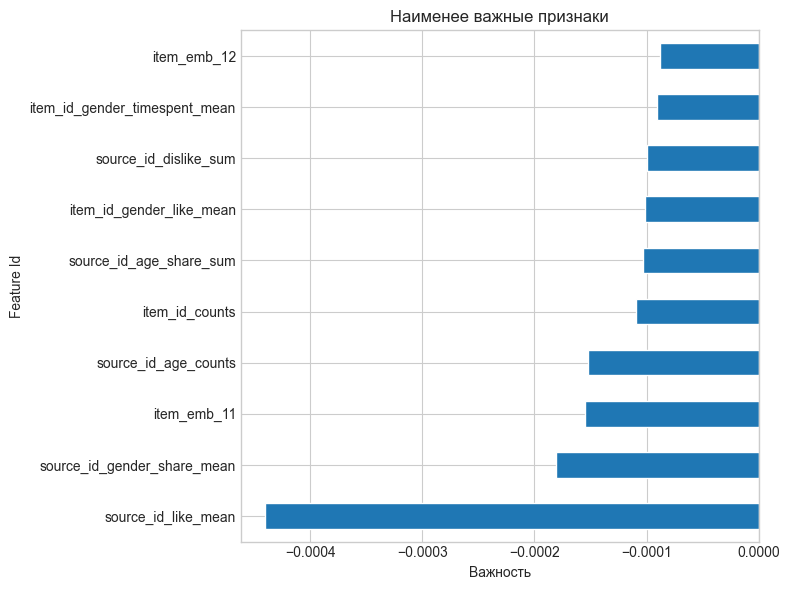

In [127]:
# Отсортировать по возрастанию и взять 10 признаков с минимальной важностью
least_important = importances.sort_values(by='Importances').head(10)

# Построить горизонтальный график
least_important.plot.barh(x='Feature Id', y='Importances', figsize=(8, 6), legend=False)
plt.title("Наименее важные признаки")
plt.xlabel("Важность")
plt.tight_layout()
plt.show()


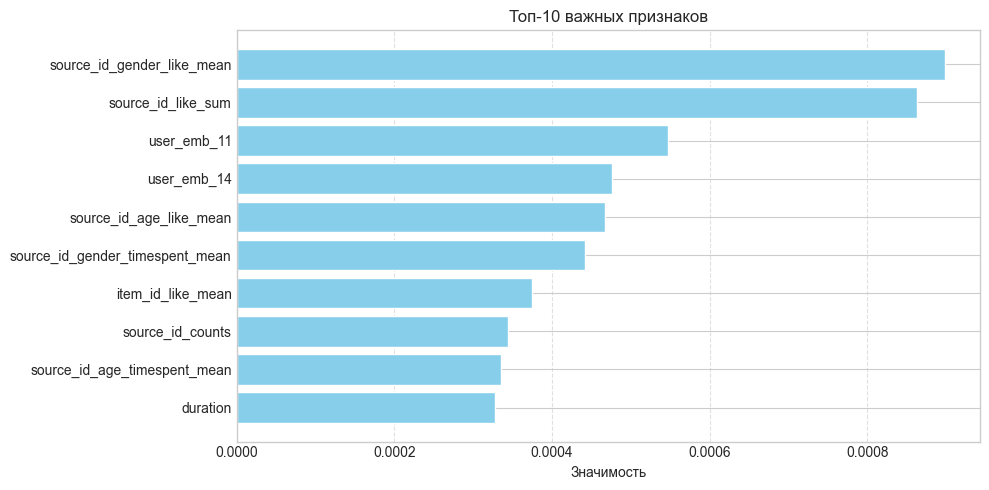

In [123]:
import matplotlib.pyplot as plt

# Получаем важность признаков и берем топ-10
importances = model_catboost.get_feature_importance(train_pool, prettified=True)
top_10 = importances.head(10)

# Строим график
plt.figure(figsize=(10, 5))
plt.barh(top_10['Feature Id'], top_10['Importances'], color='skyblue')
plt.title('Топ-10 важных признаков')
plt.xlabel('Значимость')
plt.gca().invert_yaxis()  # Самый важный признак сверху
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Удаление признаков

In [96]:
importances = model_catboost.get_feature_importance(train_pool, prettified=True)
normal_features = importances[:140]['Feature Id'].dropna().unique().tolist()
filtered_train_features = train_features[normal_features]
filtered_test_features = test_features[normal_features]
filtered_train_features

,source_id_gender_like_mean,source_id_like_sum,user_emb_11,user_emb_14,source_id_age_like_mean,source_id_gender_timespent_mean,item_id_like_mean,source_id_counts,source_id_age_timespent_mean,duration,...,item_emb_12,item_id_gender_timespent_mean,source_id_dislike_sum,item_id_gender_like_mean,source_id_age_share_sum,item_id_counts,source_id_age_counts,item_emb_11,source_id_gender_share_mean,source_id_like_mean
0,0.019231,1.0,6.262352e-15,1.325775e-13,0.000000,12.211538,0.333333,53.0,8.333333,8,...,4.736666e-12,14.000000,0.0,0.333333,0.0,3.0,3.0,6.283507e-12,0.019231,0.018868
1,0.042735,27.0,6.262352e-15,1.325775e-13,0.058824,45.592594,0.000000,661.0,50.294117,77,...,1.080906e-12,76.857140,1.0,0.000000,0.0,7.0,17.0,-1.411436e-13,0.005698,0.040847
2,0.005682,3.0,6.262352e-15,1.325775e-13,0.166667,23.261364,0.000000,183.0,33.666668,18,...,1.569260e-12,7.000000,0.0,0.000000,0.0,1.0,6.0,7.938804e-13,0.022727,0.016393
3,0.068878,28.0,6.262352e-15,1.325775e-13,0.000000,20.992348,NaN,451.0,9.666667,20,...,NaN,-1.000000,0.0,NaN,0.0,0.0,12.0,NaN,0.020408,0.062084
4,0.050251,10.0,6.262352e-15,1.325775e-13,0.000000,23.562815,0.000000,219.0,11.000000,15,...,4.886089e-12,2.000000,0.0,0.000000,0.0,1.0,3.0,4.671693e-12,0.005025,0.045662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27284,0.057534,174.0,1.066900e-03,1.141761e-04,0.095890,14.928767,0.022831,1920.0,25.150684,22,...,NaN,14.550000,0.0,0.006250,1.0,438.0,73.0,NaN,0.013699,0.090625
27285,0.017682,23.0,1.066900e-03,1.141761e-04,0.000000,17.728880,0.000000,1323.0,17.348837,48,...,NaN,20.619047,0.0,0.000000,0.0,34.0,43.0,NaN,0.003929,0.017385
27286,0.065217,10.0,1.066900e-03,1.141761e-04,0.125000,22.695652,0.000000,141.0,20.875000,53,...,NaN,34.266666,0.0,0.000000,0.0,15.0,8.0,NaN,0.000000,0.070922
27287,0.000000,7.0,1.066900e-03,1.141761e-04,0.000000,27.059406,0.000000,165.0,30.875000,174,...,NaN,176.000000,0.0,0.000000,0.0,1.0,8.0,NaN,0.000000,0.042424


In [97]:
train_pool2 = catboost.Pool(
    data=filtered_train_features,
    label=train['target'],
    group_id=train['user_id'],
)
test_pool2 = catboost.Pool(
    data=filtered_test_features,
    label=test['target'],
    group_id=test['user_id'],
)

In [98]:
params_cat = {
    'iterations': 200,
    'depth': 7,
    'learning_rate': 0.03,
    'eval_metric': 'NDCG:top=4',
    'loss_function': 'YetiRank',
    'early_stopping_rounds': 500,
    'task_type': 'CPU',
    'devices': '0',
}

# Создание модели
model_catboost2 = CatBoostRanker(**params_cat)

# Обучение
model_catboost2.fit(
    train_pool2,
    eval_set=test_pool2,
    verbose=10
)
0.7990437803
0.7995910793/100
0.7968898139/120

0:	test: 0.7845139	best: 0.7845139 (0)	total: 31.6ms	remaining: 6.29s
10:	test: 0.7933633	best: 0.7933633 (10)	total: 306ms	remaining: 5.25s
20:	test: 0.7933005	best: 0.7952920 (15)	total: 534ms	remaining: 4.55s
30:	test: 0.7941759	best: 0.7952920 (15)	total: 761ms	remaining: 4.15s
40:	test: 0.7943348	best: 0.7953705 (31)	total: 970ms	remaining: 3.76s
50:	test: 0.7940583	best: 0.7953705 (31)	total: 1.17s	remaining: 3.42s
60:	test: 0.7960952	best: 0.7960952 (60)	total: 1.39s	remaining: 3.17s
70:	test: 0.7954001	best: 0.7961861 (68)	total: 1.64s	remaining: 2.99s
80:	test: 0.7958826	best: 0.7968086 (79)	total: 1.84s	remaining: 2.71s
90:	test: 0.7957092	best: 0.7968086 (79)	total: 2.04s	remaining: 2.45s
100:	test: 0.7954514	best: 0.7968086 (79)	total: 2.25s	remaining: 2.2s
110:	test: 0.7950339	best: 0.7968086 (79)	total: 2.5s	remaining: 2s
120:	test: 0.7962800	best: 0.7968086 (79)	total: 2.7s	remaining: 1.76s
130:	test: 0.7951984	best: 0.7969190 (123)	total: 2.91s	remaining: 1.53s
140:	tes

0.006640748449166667

## Разные метрики

In [47]:
def evaluate_ranking_catboost(model, pool, user_ids, k_list=[4, 10]):
    """
    Оценивает CatBoost модель по ранжированию отдельно для каждого пользователя.

    :param model: Обученная модель CatBoost
    :param pool: Тестовый пул данных (catboost.Pool)
    :param user_ids: Список user_id для каждой строки в pool
    :param k_list: Массив значений k для подсчёта Precision@k и NDCG@k
    """
    # Получаем метки и предсказания из Pool
    y_true = pool.get_label()
    y_pred_scores = model.predict(pool)

    # Переводим в датафрейм для удобства
    df = pd.DataFrame({
        'user_id': user_ids,
        'true_label': y_true,
        'pred_score': y_pred_scores
    })

    metrics = {f'NDCG@{k}': [] for k in k_list}
    metrics.update({f'Precision@{k}': [] for k in k_list})
    metrics['MRR'] = []
    metrics['MAP'] = []

    # Проходим по каждому пользователю отдельно
    for user_id, group in df.groupby('user_id'):
        true_labels = group['true_label'].values
        pred_scores = group['pred_score'].values

        if len(true_labels) == 0:
            continue

        # Превращаем метки в бинарные: 1 - релевантный, 0 - нет
        true_binary = (true_labels == 1).astype(int)

        # Сортируем по предсказанному скору
        sorted_idx = np.argsort(-pred_scores)
        sorted_true = true_binary[sorted_idx]
        sorted_pred_scores = pred_scores[sorted_idx]

        for k in k_list:
            # NDCG@k
            ndcg = ndcg_score([true_binary], [sorted_pred_scores], k=k)
            metrics[f'NDCG@{k}'].append(ndcg)

            # Precision@k
            top_k = sorted_true[:k]
            precision = np.mean(top_k)
            metrics[f'Precision@{k}'].append(precision)

        # MRR
        rel_idx = np.where(sorted_true == 1)[0]
        mrr = 1 / (rel_idx[0] + 1) if len(rel_idx) > 0 else 0
        metrics['MRR'].append(mrr)

        # MAP
        ap = average_precision_score(true_binary, pred_scores)
        metrics['MAP'].append(ap)

    # Усредняем все метрики
    final_metrics = {key: np.mean(values) for key, values in metrics.items()}

    print("\n🔹 Исправленные метрики ранжирования (по пользователям):")
    for metric, value in final_metrics.items():
        print(f"{metric}: {value:.4f}")

    return final_metrics

In [48]:
test_pool.get_label().min()

0

In [49]:
metrics_catboost = evaluate_ranking_catboost(model_catboost, test_pool, user_ids=test['user_id'].values, k_list=[4, 10])


🔹 Исправленные метрики ранжирования (по пользователям):
NDCG@4: 0.8261
NDCG@10: 0.8658
Precision@4: 0.7449
Precision@10: 0.7552
MRR: 0.8451
MAP: 0.8157


C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [50]:
pred = model_catboost.predict(test_pool)
target_for_roc_auc = test['target'].values - 1
pred_roc_auc_catBoost = custom_roc_auc(pred, target_for_roc_auc, test.groupby('user_id').size().values)
metrics_catboost['ROC AUC'] = pred_roc_auc_catBoost

print("ROC AUC", pred_roc_auc_catBoost)

ROC AUC 0.5538788534473631


# XGBoost

In [51]:
# Определяем параметры, аналогичные вашему CatBoost
time_xgboost = time.time()
params_xgb = {
    'max_depth': 6,
    'learning_rate': 0.03,
    'objective': 'rank:ndcg',
    'eval_metric': 'ndcg',
    'tree_method': 'hist',
    'device': 'cpu',
    'colsample_bytree': 1.0,
    'subsample': 0.8,
    'min_child_weight': 1
}

evals_result_xgboost = {}

group_sizes = train.groupby('user_id').size().values
train_dmatrix = xgb.DMatrix(
    data=train_features,
    label=train['target'],
)
train_dmatrix.set_group(group_sizes)

group_sizes_test = test.groupby('user_id').size().values
test_dmatrix = xgb.DMatrix(
    data=test_features,
    label=test['target'],
)
test_dmatrix.set_group(group_sizes_test)

modelXGB = xgb.train(
    params=params_xgb,
    dtrain=train_dmatrix,
    num_boost_round=N,  # Количество итераций
    evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],
    evals_result=evals_result_xgboost,
    verbose_eval=10,  # Выводить информацию о каждой итерации
    early_stopping_rounds=100  # Остановка, если метрика не улучшается 100 итераций
)
time_xgboost = time.time() - time_xgboost

[0]	train-ndcg:0.85359	test-ndcg:0.84942
[10]	train-ndcg:0.91244	test-ndcg:0.85247
[20]	train-ndcg:0.92805	test-ndcg:0.85368
[30]	train-ndcg:0.93495	test-ndcg:0.85396
[40]	train-ndcg:0.94112	test-ndcg:0.85263
[50]	train-ndcg:0.94531	test-ndcg:0.85390
[60]	train-ndcg:0.94747	test-ndcg:0.85362
[70]	train-ndcg:0.94953	test-ndcg:0.85373
[80]	train-ndcg:0.95215	test-ndcg:0.85266
[90]	train-ndcg:0.95434	test-ndcg:0.85353
[99]	train-ndcg:0.95579	test-ndcg:0.85382


In [52]:
def evaluate_ranking_xgb(model, dmatrix, user_ids, k_list=[4, 10]):
    """
    Оценивает XGBoost модель по ранжированию отдельно для каждого пользователя.

    :param model: Обученная модель XGBoost (Booster)
    :param dmatrix: DMatrix с фичами и таргетами
    :param user_ids: Список user_id для каждой строки в dmatrix
    :param k_list: Массив значений k для подсчёта Precision@k и NDCG@k
    """
    y_true = dmatrix.get_label()
    y_pred_scores = model.predict(dmatrix)

    # Переводим в датафрейм для удобства
    df = pd.DataFrame({
        'user_id': user_ids,
        'true_label': y_true,
        'pred_score': y_pred_scores
    })

    metrics = {f'NDCG@{k}': [] for k in k_list}
    metrics.update({f'Precision@{k}': [] for k in k_list})
    metrics['MRR'] = []
    metrics['MAP'] = []

    # Проходим по каждому пользователю отдельно
    for user_id, group in df.groupby('user_id'):
        true_labels = group['true_label'].values
        pred_scores = group['pred_score'].values

        if len(true_labels) == 0:
            continue

        # Превращаем метки в бинарные: 1 - релевантный, 0 - нет
        true_binary = (true_labels == 1).astype(int)

        # Сортируем по предсказанному скору
        sorted_idx = np.argsort(-pred_scores)
        sorted_true = true_binary[sorted_idx]

        for k in k_list:
            # NDCG@k
            ndcg = ndcg_score([true_binary], [pred_scores], k=k)
            metrics[f'NDCG@{k}'].append(ndcg)

            # Precision@k
            top_k = sorted_true[:k]
            precision = np.mean(top_k)
            metrics[f'Precision@{k}'].append(precision)

        # MRR
        rel_idx = np.where(sorted_true == 1)[0]
        mrr = 1 / (rel_idx[0] + 1) if len(rel_idx) > 0 else 0
        metrics['MRR'].append(mrr)

        # MAP
        ap = average_precision_score(true_binary, pred_scores)
        metrics['MAP'].append(ap)

    # Усредняем все метрики
    final_metrics = {key: np.mean(values) for key, values in metrics.items()}

    print("\n🔹 Исправленные метрики ранжирования (по пользователям):")
    for metric, value in final_metrics.items():
        print(f"{metric}: {value:.4f}")

    return final_metrics


In [53]:
metrics_XGBoost = evaluate_ranking_xgb(modelXGB, test_dmatrix, user_ids=test['user_id'].values, k_list=[4, 10])


🔹 Исправленные метрики ранжирования (по пользователям):
NDCG@4: 0.8035
NDCG@10: 0.8510
Precision@4: 0.7449
Precision@10: 0.7551
MRR: 0.8493
MAP: 0.8175


C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [54]:
# Предсказание scores
train_preds = modelXGB.predict(train_dmatrix)  # Scores для тренировочных данных
test_preds = modelXGB.predict(test_dmatrix)    # Scores для тестовых данных

# Вычисление ROCAUC вручную
train_preds_for_XGB = train['target'].values - 1
test_preds_for_XGB = test['target'].values - 1
train_roc_auc = custom_roc_auc(train_preds, train_preds_for_XGB, group_sizes)
test_roc_auc = custom_roc_auc(test_preds, test_preds_for_XGB, group_sizes_test)
metrics_XGBoost['ROC AUC'] = test_roc_auc

print(f"Train ROCAUC: {train_roc_auc}")
print(f"Test ROCAUC: {test_roc_auc}")

Train ROCAUC: 0.8784800235947289
Test ROCAUC: 0.5554302307203725


100 итераций. 7 глубина.&ensp;
Train ROCAUC: 0.6670716689461378
Test ROCAUC: 0.6003733483248678<br>
100 итераций. 5 глубина.$~~$
Train ROCAUC: 0.6311736373806708
Test ROCAUC: 0.6001191879930137<br>
1000 итераций. 5 глубина.
Train ROCAUC: 0.6691902340867639
Test ROCAUC: 0.604593486315108<br>
1000 итераций. 5 глубина.
Train ROCAUC: 0.7116123450389218
Test ROCAUC: 0.6041953575554416 (c_f + ALS(все фичи))<br>
Нужен подбор гиперпараметров!


# LightGBM

In [55]:
# Подготовка данных для LightGBM
time_lightgbm = time.time()
train_lgb = lgb.Dataset(
    data=train_features,
    label=train['target'],
    group=train.groupby('user_id').size().values  # Группировка по user_id
)

test_lgb = lgb.Dataset(
    data=test_features,
    label=test['target'],
    group=test.groupby('user_id').size().values,
    reference=train_lgb,
    free_raw_data=False
)

evals_result_lightgbm = {}

# Параметры (аналогично вашим настройкам XGBoost)
params_lgb = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.01,  # Уменьшите learning_rate
    'max_depth': 6,         # Уменьшите глубину деревьев
    # 'num_leaves': 15,       # Ограничьте число листьев
    'min_child_weight': 5,  # Увеличьте для борьбы с переобучением
    'subsample': 0.7,       # Субсемплинг данных
    'colsample_bytree': 0.7, # Субсемплинг фичей
    'lambda_l1': 1.0,       # L1-регуляризация
    'lambda_l2': 1.0,       # L2-регуляризация
    'early_stopping_rounds': 100,
}

model_lgb = lgb.train(
    params=params_lgb,
    train_set=train_lgb,
    num_boost_round=N,
    valid_sets=[test_lgb],
    valid_names=['test'],
    callbacks=[
        lgb.record_evaluation(evals_result_lightgbm),
        lgb.log_evaluation(10),  # Логи каждые 10 итераций
        #lgb.early_stopping(50)  # Ранняя остановка
    ]
)
time_lightgbm = time.time() - time_lightgbm

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=6) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=64) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=6) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=64) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16522
[LightGBM] [Info] Number of data points in the train set: 27289, number of used features: 133
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=6) without explicitly setting 'num

In [56]:
def evaluate_ranking_lgb(model, test_data, user_ids, k_list=[4, 10]):
    """
    Оценивает LightGBM модель по ранжированию отдельно для каждого пользователя.

    :param model: Обученная модель LightGBM
    :param test_data: Данные для тестирования в виде pandas DataFrame или numpy array
    :param user_ids: Список user_id для каждой строки в test_data
    :param k_list: Массив значений k для подсчёта Precision@k и NDCG@k
    """
    # Получаем метки и предсказания
    y_true = test_data
    # test_features = test_data.get_data().drop(columns=['user_id', 'target']).values  # убираем target и user_id

    # Получаем предсказания
    y_pred_scores = model.predict(test_features)

    # Переводим в датафрейм для удобства
    df = pd.DataFrame({
        'user_id': user_ids,
        'true_label': y_true,
        'pred_score': y_pred_scores
    })

    metrics = {f'NDCG@{k}': [] for k in k_list}
    metrics.update({f'Precision@{k}': [] for k in k_list})
    metrics['MRR'] = []
    metrics['MAP'] = []

    # Проходим по каждому пользователю отдельно
    for user_id, group in df.groupby('user_id'):
        true_labels = group['true_label'].values
        pred_scores = group['pred_score'].values

        if len(true_labels) == 0:
            continue

        # Превращаем метки в бинарные: 1 - релевантный, 0 - нет
        true_binary = (true_labels == 1).astype(int)

        # Сортируем по предсказанному скору
        sorted_idx = np.argsort(-pred_scores)
        sorted_true = true_binary[sorted_idx]
        sorted_pred_scores = pred_scores[sorted_idx]

        for k in k_list:
            # NDCG@k
            ndcg = ndcg_score([true_binary], [sorted_pred_scores], k=k)
            metrics[f'NDCG@{k}'].append(ndcg)

            # Precision@k
            top_k = sorted_true[:k]
            precision = np.mean(top_k)
            metrics[f'Precision@{k}'].append(precision)

        # MRR
        rel_idx = np.where(sorted_true == 1)[0]
        mrr = 1 / (rel_idx[0] + 1) if len(rel_idx) > 0 else 0
        metrics['MRR'].append(mrr)

        # MAP
        ap = average_precision_score(true_binary, pred_scores)
        metrics['MAP'].append(ap)

    # Усредняем все метрики
    final_metrics = {key: np.mean(values) for key, values in metrics.items()}

    print("\n🔹 Метрики ранжирования (по пользователям) для LightGBM:")
    for metric, value in final_metrics.items():
        print(f"{metric}: {value:.4f}")

    return final_metrics


In [57]:
metrics_LightGBM = evaluate_ranking_lgb(model_lgb, test['target'].values, user_ids=test['user_id'].values, k_list=[4, 10])



🔹 Метрики ранжирования (по пользователям) для LightGBM:
NDCG@4: 0.8259
NDCG@10: 0.8655
Precision@4: 0.7409
Precision@10: 0.7544
MRR: 0.8417
MAP: 0.8133


C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [58]:
# Предсказание
train_preds = model_lgb.predict(train_features)
test_preds = model_lgb.predict(test_features)

# Группировка по user_id (аналогично вашему коду)
group_sizes = train.groupby('user_id').size().values
group_sizes_test = test.groupby('user_id').size().values

train_preds_for_LGBM = train['target'].values - 1
test_preds_for_LGBM = test['target'].values - 1

# Вычисление ROCAUC
train_roc_auc = custom_roc_auc(train_preds, train_preds_for_LGBM, group_sizes)
test_roc_auc = custom_roc_auc(test_preds, test_preds_for_LGBM, group_sizes_test)
metrics_LightGBM['ROC AUC'] = test_roc_auc

print(f"Train ROCAUC: {train_roc_auc:.4f}")
print(f"Test ROCAUC: {test_roc_auc:.4f}")

Train ROCAUC: 0.7643
Test ROCAUC: 0.5631


38 итераций(автоматом остановился). Глубина 6:<br>
Train ROCAUC: 0.6297
Test ROCAUC: 0.6000<br>
1000 итераций. Глубина 6:<br>
Train ROCAUC: 0.7082
Test ROCAUC: 0.6013<br>
Нужен подбор гиперпараметров!

# Анализ

In [59]:
print(metrics_catboost['NDCG@4'])
print(metrics_XGBoost['NDCG@4'])
print(metrics_LightGBM['NDCG@4'])

print(f"Время исполнения:\nCatBoost: {time_catboost}\nXGBoost:  {time_xgboost}\nLightGBM: {time_lightgbm}")

0.8260940962894568
0.8035325309926007
0.8258647284558687
Время исполнения:
CatBoost: 3.921391487121582
XGBoost:  0.9996140003204346
LightGBM: 0.5939905643463135


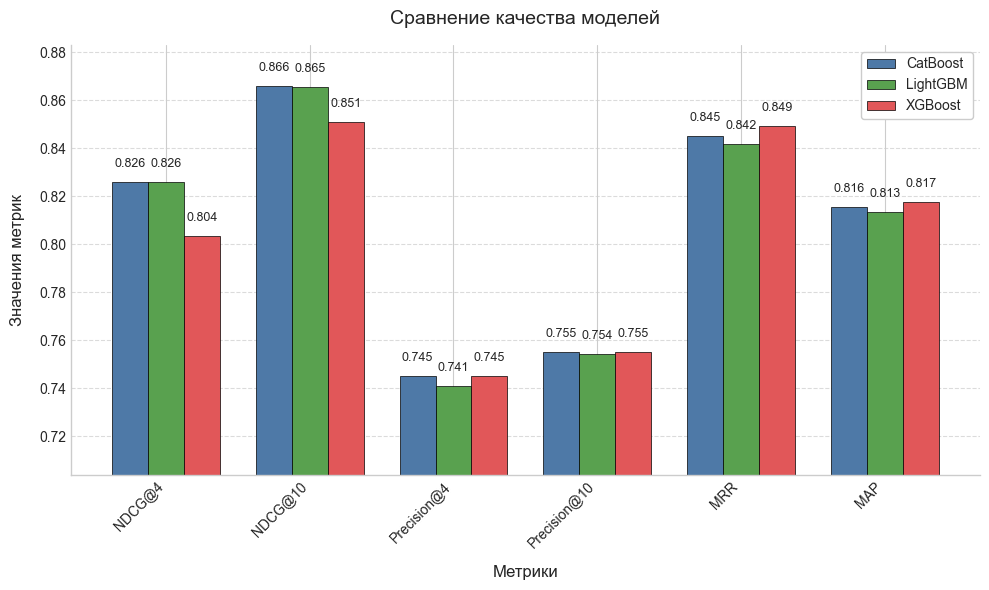

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Проверка доступных стилей (можно раскомментировать для проверки)
# print(plt.style.available)

# Названия метрик (исключая ROC AUC)
metrics_names = list(metrics_catboost.keys())
metrics_to_plot = [name for name in metrics_names if name != 'ROC AUC']

# Значения метрик
catboost_filtered = [metrics_catboost[name] for name in metrics_to_plot]
lightgbm_filtered = [metrics_LightGBM[name] for name in metrics_to_plot]
xgboost_filtered = [metrics_XGBoost[name] for name in metrics_to_plot]

# Расчет границ оси Y
min_value = min(min(catboost_filtered), min(lightgbm_filtered), min(xgboost_filtered)) * 0.95
max_value = max(max(catboost_filtered), max(lightgbm_filtered), max(xgboost_filtered)) * 1.02

# Применение правильного стиля seaborn
plt.style.use('seaborn-v0_8-whitegrid')  # Современный вариант
# Альтернативные варианты:
# plt.style.use('seaborn')  # Базовый стиль
# plt.style.use('ggplot')   # Другой популярный стиль

colors = ['#4E79A7', '#59A14F', '#E15759']  # Академические цвета

# Параметры графика
bar_width = 0.25
index = np.arange(len(metrics_to_plot))
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Создание столбцов
bars1 = ax.bar(index - bar_width, catboost_filtered, bar_width,
              label='CatBoost', color=colors[0], edgecolor='black', linewidth=0.5)
bars2 = ax.bar(index, lightgbm_filtered, bar_width,
              label='LightGBM', color=colors[1], edgecolor='black', linewidth=0.5)
bars3 = ax.bar(index + bar_width, xgboost_filtered, bar_width,
              label='XGBoost', color=colors[2], edgecolor='black', linewidth=0.5)

# Функция для добавления значений на столбцы
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

add_values(bars1)
add_values(bars2)
add_values(bars3)

# Настройка осей и заголовка
ax.set_xlabel('Метрики', fontsize=12, labelpad=10)
ax.set_ylabel('Значения метрик', fontsize=12, labelpad=10)
ax.set_title('Сравнение качества моделей', fontsize=14, pad=15)
ax.set_xticks(index)
ax.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax.set_ylim(min_value, max_value)
ax.legend(frameon=True, framealpha=1)

# Улучшение оформления
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

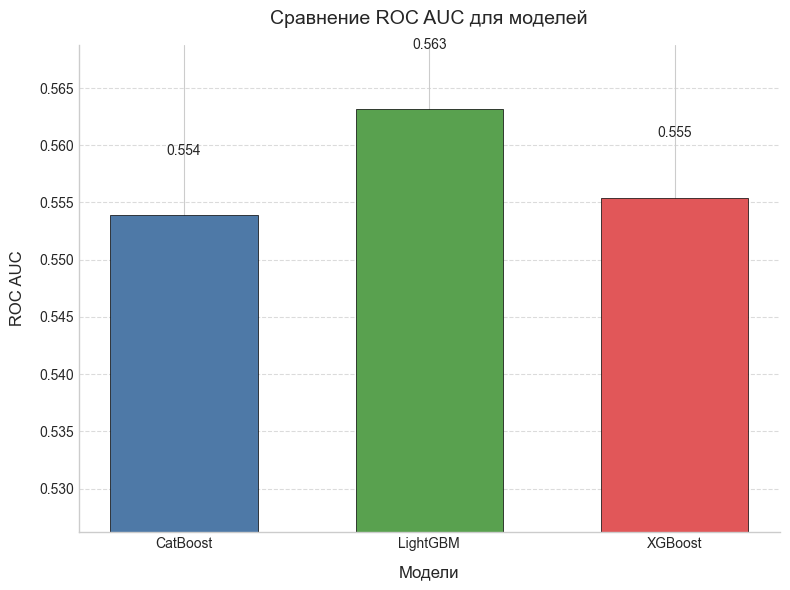

In [61]:
import matplotlib.pyplot as plt

# Извлекаем значения ROC AUC
roc_auc_values = {
    'CatBoost': metrics_catboost['ROC AUC'],
    'LightGBM': metrics_LightGBM['ROC AUC'],
    'XGBoost': metrics_XGBoost['ROC AUC']
}

# Настройка диапазона оси Y
min_value = min(roc_auc_values.values()) * 0.95
max_value = max(roc_auc_values.values()) * 1.01

# Академическая цветовая палитра (как в Nature/Science)
colors = [
    '#4E79A7',  # Синий (как в Tableau)
    '#59A14F',  # Зеленый
    '#E15759'   # Красный
]

# Создаем фигуру
plt.figure(figsize=(8, 6), dpi=100)
ax = plt.gca()

# Столбчатая диаграмма с настройками
bars = ax.bar(
    roc_auc_values.keys(),
    roc_auc_values.values(),
    color=colors,
    edgecolor='black',
    linewidth=0.5,
    width=0.6
)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.005,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Настройки осей и заголовка
plt.ylim(min_value, max_value)
plt.xlabel('Модели', fontsize=12, labelpad=10)
plt.ylabel('ROC AUC', fontsize=12, labelpad=10)
plt.title('Сравнение ROC AUC для моделей', fontsize=14, pad=15)

# Сетка и оформление
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

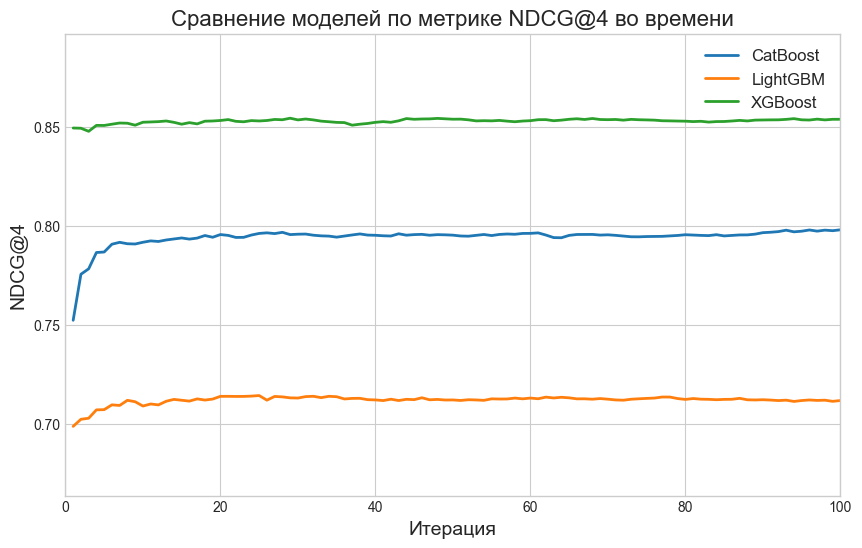

In [62]:
# Создаём сам холст
plt.figure(figsize=(10, 6))

# Добавляем CatBoost
catboost_metric = evals_result_catboost['validation']['NDCG:top=4;type=Base']
plt.plot(range(1, len(catboost_metric) + 1), catboost_metric, label='CatBoost', linewidth=2)

# Добавляем LightGBM
lightgbm_metric = evals_result_lightgbm['test']['ndcg@4']
plt.plot(range(1, len(lightgbm_metric) + 1), lightgbm_metric, label='LightGBM', linewidth=2)

# Добавляем XGBoost
xgboost_metric = evals_result_xgboost['test']['ndcg']
plt.plot(range(1, len(xgboost_metric) + 1), xgboost_metric, label='XGBoost', linewidth=2)

min_catboost = min(catboost_metric)
min_lightgbm = min(lightgbm_metric)
min_xgboost = min(xgboost_metric)
min_value = min(min_catboost, min_lightgbm, min_xgboost) * 0.95

max_catboost = max(catboost_metric)
max_lightgbm = max(lightgbm_metric)
max_xgboost = max(xgboost_metric)
max_value = max(max_catboost, max_lightgbm, max_xgboost) * 1.05

# Украшаем картину
plt.title('Сравнение моделей по метрике NDCG@4 во времени', fontsize=16)
plt.xlabel('Итерация', fontsize=14)
plt.ylabel('NDCG@4', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(min_value, max_value)  # Чтобы всё выглядело чинно
plt.xlim(0, 100)  # Чтобы всё выглядело чинно
plt.show()


In [63]:
import numpy as np
import pandas as pd

def compute_simple_recall(model, pool, user_ids, k=3, true_labels=None):
    """
    Считает Recall@k для модели.

    :param model: обученная модель
    :param pool: тестовый набор (CatBoostPool, LightGBM Dataset, DMatrix или просто фичи)
    :param user_ids: список user_id для каждой строки
    :param k: топ-k элементов
    :param true_labels: если pool - это не объект с метками, нужно отдельно передать метки
    :return: Recall@k
    """

    # Предсказания
    y_pred_scores = model.predict(pool)

    # Настоящие метки
    if true_labels is not None:
        y_true = true_labels
    elif hasattr(pool, 'get_label'):
        y_true = pool.get_label()
    elif hasattr(pool, 'get_label_values'):
        y_true = pool.get_label_values()
    else:
        raise ValueError("Не удалось получить целевые метки. Передайте true_labels вручную.")

    # Объединяем в DataFrame
    df = pd.DataFrame({
        'user_id': user_ids,
        'true_label': y_true,
        'pred_score': y_pred_scores
    })

    recalls = []
    for user_id, group in df.groupby('user_id'):
        true_labels = group['true_label'].values
        pred_scores = group['pred_score'].values

        sorted_idx = np.argsort(-pred_scores)
        top_k_true = true_labels[sorted_idx][:k]

        recalls.append(int(np.any(top_k_true == 1)))

    return np.mean(recalls)


In [64]:
k = 2
recall_catboost = compute_simple_recall(model_catboost, test_pool, test['user_id'].values, k)
recall_lightgbm = compute_simple_recall(model_lgb, test_features, test['user_id'].values, k, true_labels=test['target'].values)
recall_xgboost = compute_simple_recall(modelXGB, test_dmatrix, test['user_id'].values, k)

print(f"Recall@3 CatBoost: {recall_catboost:.2%}")
print(f"Recall@3 LightGBM: {recall_lightgbm:.2%}")
print(f"Recall@3 XGBoost: {recall_xgboost:.2%}")

Recall@3 CatBoost: 93.74%
Recall@3 LightGBM: 93.93%
Recall@3 XGBoost: 95.15%


In [65]:
k = 10
recall_catboost = compute_simple_recall(model_catboost, test_pool, test['user_id'].values, k=10)
recall_lightgbm = compute_simple_recall(model_lgb, test_features, test['user_id'].values, k=10, true_labels=test['target'].values)
recall_xgboost = compute_simple_recall(modelXGB, test_dmatrix, test['user_id'].values, k=10)

print(f"Recall@3 CatBoost: {recall_catboost:.2%}")
print(f"Recall@3 LightGBM: {recall_lightgbm:.2%}")
print(f"Recall@3 XGBoost: {recall_xgboost:.2%}")


Recall@3 CatBoost: 99.95%
Recall@3 LightGBM: 99.91%
Recall@3 XGBoost: 99.95%


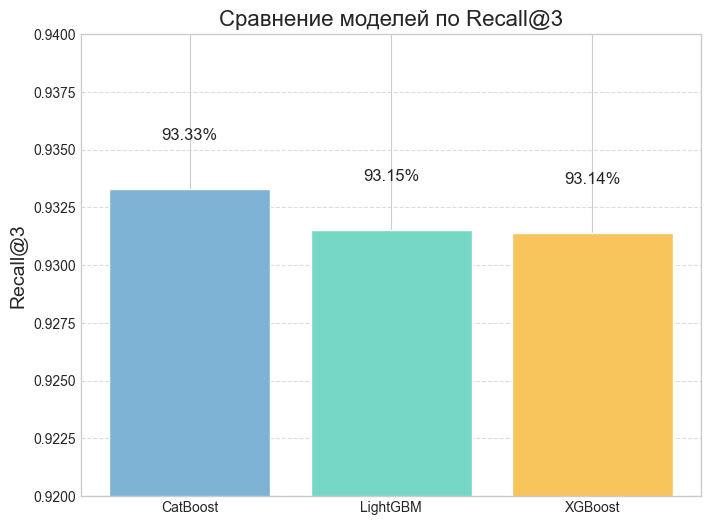

In [66]:
import matplotlib.pyplot as plt

# Данные Recall@3 для каждой модели
models = ['CatBoost', 'LightGBM', 'XGBoost']
recall_scores = [0.9333, 0.9315, 0.9314]  # ваши значения в долях

# Построение графика
plt.figure(figsize=(8, 6))
bars = plt.bar(models, recall_scores, color=['#7FB3D5', '#76D7C4', '#F7C55C'])

# Подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002, f'{height:.2%}', ha='center', va='bottom', fontsize=12)

# Настройка внешнего вида
plt.ylim(0.92, 0.94)  # Ограничиваем ось Y, чтобы видеть разницу лучше
plt.ylabel('Recall@3', fontsize=14)
plt.title('Сравнение моделей по Recall@3', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Графики